# Задача классификации: предсказание качества вина

## 1. Загрузка данных

Загружаем датасет Wine Quality из sklearn, он содержит физико-химические характеристики красного вина из Португалии. Цель - предсказать качество вина (бинарная классификация: хорошее/плохое). Датасет содержит около 1600 строк и 11 признаков

Описание датасета
- fixed acidity - фиксированная кислотность
- volatile acidity - летучая кислотность  
- citric acid - лимонная кислота
- residual sugar - остаточный сахар
- chlorides - хлориды
- free sulfur dioxide - свободный SO2
- total sulfur dioxide - общий SO2
- density - плотность
- pH - кислотность
- sulphates - сульфаты
- alcohol - алкоголь (% по объёму)
- quality - оценка сомелье от 0 (очень плохое) до 10 (отличное)

Бинарная классификация:
- quality 3-5 - класс 0 = плохое/среднее вино
- quality 6-8 - класс 1 = хорошее вино
- Порог >=6 выбран по статье, что указана по ссылке датасета (Cortez et al., "Modeling wine preferences by data mining from physicochemical properties", Decision Support Systems, 2009 (UCI ML Repository)): вина с оценкой 6+ считаются хорошими


Датасет доступен из UCI ML Repository, содержит 1599 примеров, все признаки числовые, пропусков нет

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

data['target'] = (data['quality'] >= 6).astype(int)
data = data.drop('quality', axis=1)

print(f"Размер: {data.shape}")
print(f"Классы: {data['target'].value_counts().to_dict()}")
data.head()

Размер: (1599, 12)
Классы: {1: 855, 0: 744}


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## 2. Первичный анализ данных

На этапе первичного анализа проверяем структуру данных, типы признаков, наличие пропусков и базовую статистику

In [10]:
data.info()

print("\nБазовая статистика:")
print(data.describe())

print("\nПропуски:")
miss = data.isnull().sum()
print(miss[miss > 0] if miss.sum() > 0 else "Пропусков не найдено")

print(f"\nБаланс классов:")
print(data['target'].value_counts())
print(f"Доля класса 1: {data['target'].mean()*100:.1f}%")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  target                1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

Базовая статистика:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.00

## 3. Разведочный анализ (EDA)

В этом разделе изучаем распределение целевой переменной, анализируем корреляции между признаками, выявляем взаимосвязи и получаем полезные инсайты для построения моделей

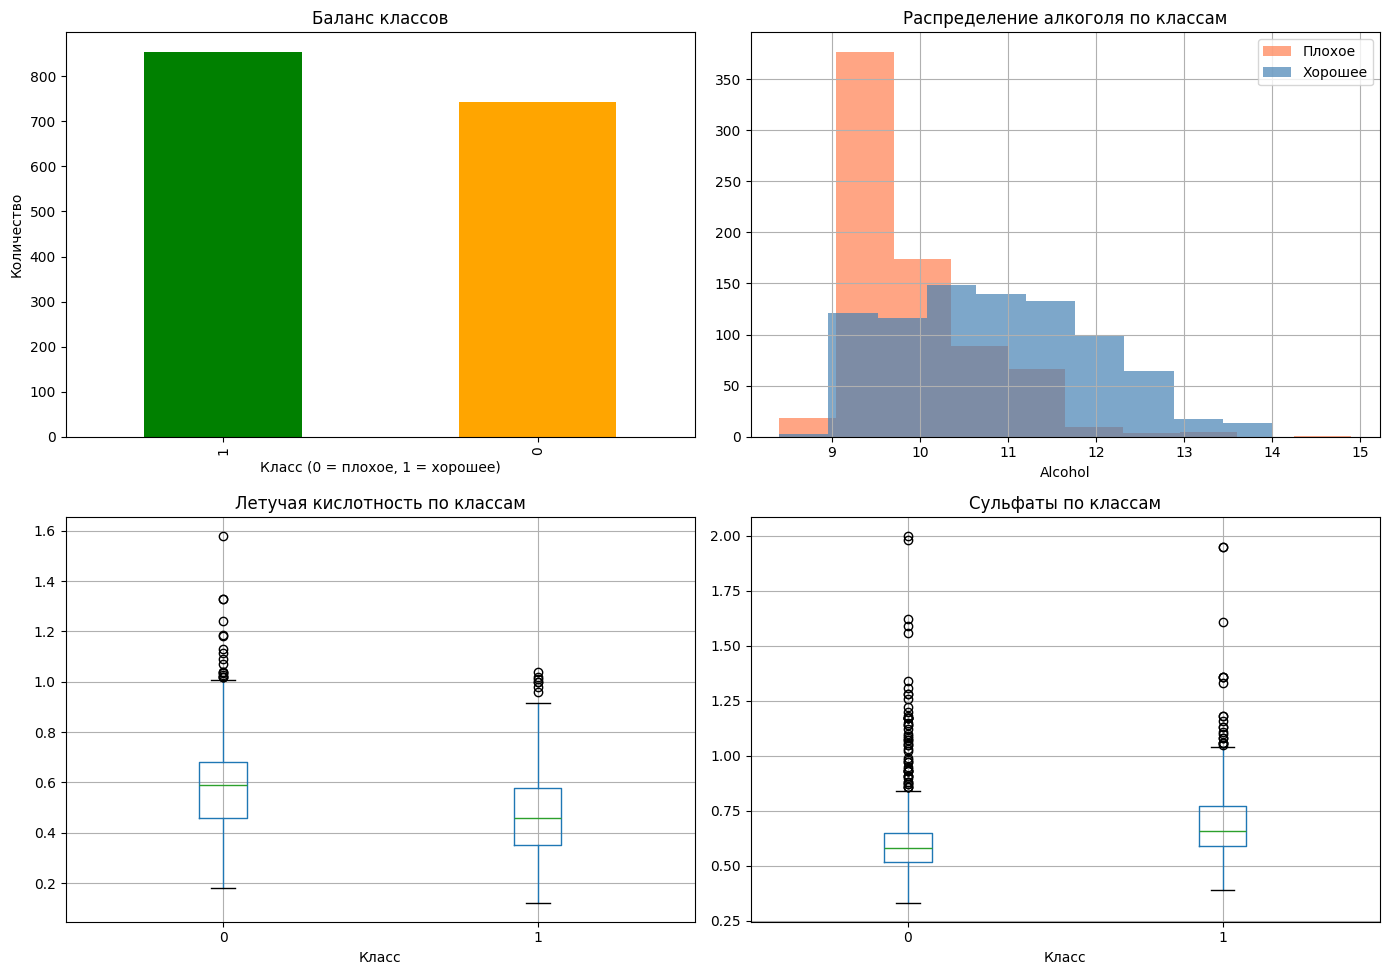

Корреляция признаков с целью:
target                  1.000000
alcohol                 0.434751
sulphates               0.218072
citric acid             0.159129
fixed acidity           0.095093
residual sugar         -0.002160
pH                     -0.003264
free sulfur dioxide    -0.061757
chlorides              -0.109494
density                -0.159110
total sulfur dioxide   -0.231963
volatile acidity       -0.321441
Name: target, dtype: float64


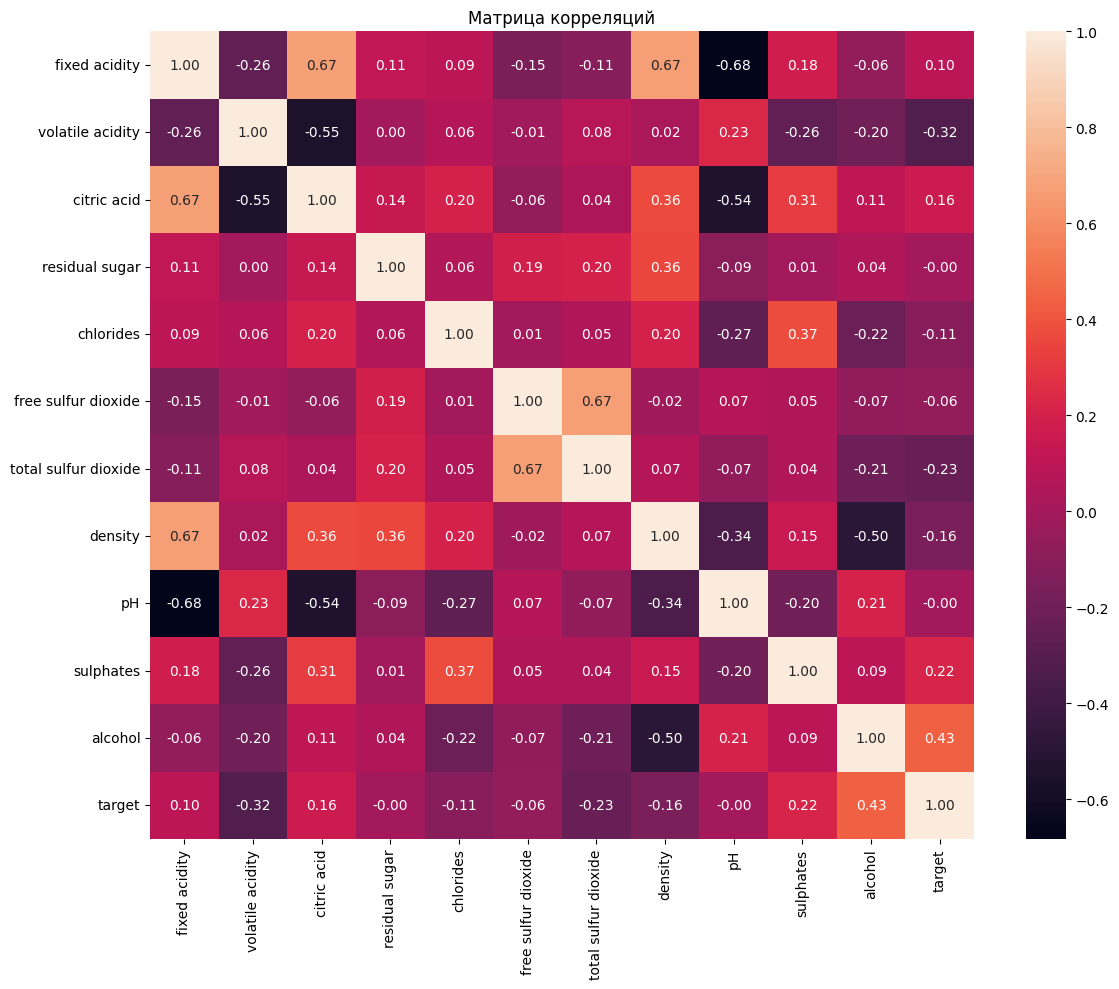


Анализ выбросов (IQR метод) для ключевых признаков (корреляция по модулю > 0.2):
volatile acidity: 19 выбросов (1.2%)
total sulfur dioxide: 55 выбросов (3.4%)
sulphates: 59 выбросов (3.7%)
alcohol: 13 выбросов (0.8%)


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
data['target'].value_counts().plot(kind='bar', ax=ax, color=['green', 'orange'])
ax.set_title('Баланс классов')
ax.set_xlabel('Класс (0 = плохое, 1 = хорошее)')
ax.set_ylabel('Количество')

ax = axes[0, 1]
data[data['target']==0]['alcohol'].hist(ax=ax, alpha=0.7, label='Плохое', color='coral')
data[data['target']==1]['alcohol'].hist(ax=ax, alpha=0.7, label='Хорошее', color='steelblue')
ax.set_title('Распределение алкоголя по классам')
ax.set_xlabel('Alcohol')
ax.legend()

ax = axes[1, 0]
data.boxplot(column='volatile acidity', by='target', ax=ax)
ax.set_title('Летучая кислотность по классам')
ax.set_xlabel('Класс')
plt.suptitle('')

ax = axes[1, 1]
data.boxplot(column='sulphates', by='target', ax=ax)
ax.set_title('Сульфаты по классам')
ax.set_xlabel('Класс')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("Корреляция признаков с целью:")
corr = data.corr()['target'].sort_values(ascending=False)
print(corr)

plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()


print("\nАнализ выбросов (IQR метод) для ключевых признаков (корреляция по модулю > 0.2):")
for col in ['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(data)*100:.1f}%)")

Выводы EDA:
- Классы несбалансированы: 53.5% хороших вин и 46.5% плохих - дисбаланс умеренный
- Отрицательная корреляция с volatile acidity (-0.32) - у плохих вин выше летучая кислотность
- Также отрацательная корреляция с total sulfur dioxide (-0.23) - у плохих вин больше общий SO2
- Положительная корреляция с sulphates (0.22) - хорошие вина содержат больше сульфатов
- Сильная положительная корреляция с alcohol (0.43) - хорошие вина содержат больше алкоголя
- Выбросов немного (0.8-3.7%), они реальны и отражают естественное разнообразие вин
- Датасет готов к использованию без удаления выбросов - tree-based модели устойчивы к ним

## 4. Подготовка данных и Feature Engineering

На этом этапе готовим данные для обучения моделей: разделяем на тренировочную и тестовую выборки, применяем масштабирование для лучшей работы алгоритмов

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop('target', axis=1)
y = data['target']

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_ts_sc = scaler.transform(X_ts)

print(f"Train: {X_tr.shape}, Test: {X_ts.shape}")
print(f"Train balance: {y_tr.mean()*100:.1f}% класса 1")
print(f"Test balance: {y_ts.mean()*100:.1f}% класса 1")

Train: (1279, 11), Test: (320, 11)
Train balance: 53.5% класса 1
Test balance: 53.4% класса 1


- Данные разделены 80/20 с сохранением баланса классов (stratify=y)
- Применено масштабирование StandardScaler
- Feature Engineering не требуется - признаки уже информативны
- Пропусков нет, типы корректные (все числовые)

## 5. Обучение четырёх моделей классификации

Обучаем четыре метода классификации с подбором гиперпараметров через GridSearchCV и c кросс-валидацией

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

models_dict = {
    'LogReg': (LogisticRegression(max_iter=1000, random_state=11), {'C': [0.1, 1.0, 10.0]}),
    'RF': (RandomForestClassifier(random_state=11), {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}),
    'GradBoost': (GradientBoostingClassifier(random_state=11), {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}),
    'SVM': (SVC(random_state=11), {'C': [0.1, 1.0, 10.0], 'kernel': ['rbf', 'linear']})
}

results = []
best_models = {}

for name, (model, params) in models_dict.items():
    print(f"\n{name}:")
    
    gs = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1, verbose=0)
    t0 = time.time()
    gs.fit(X_tr_sc, y_tr)
    train_time = time.time() - t0
    
    best_m = gs.best_estimator_
    best_models[name] = best_m
    print(f"Параметры: {gs.best_params_}, CV F1: {gs.best_score_:.4f}")
    
    t0 = time.time()
    y_pred = best_m.predict(X_ts_sc)
    pred_time = time.time() - t0
    
    acc = accuracy_score(y_ts, y_pred)
    f1 = f1_score(y_ts, y_pred)
    
    results.append({
        'Модель': name,
        'Accuracy': acc,
        'F1': f1,
        'Время_обуч': round(train_time, 3),
        'Время_пред': round(pred_time, 4)
    })
    
    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")
    print(f"Время: обуч {train_time:.2f}s, пред {pred_time:.4f}s")

print()
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))


LogReg:
Параметры: {'C': 10.0}, CV F1: 0.7539
Accuracy: 0.7469, F1: 0.7508
Время: обуч 4.47s, пред 0.0006s

RF:
Параметры: {'max_depth': 10, 'n_estimators': 100}, CV F1: 0.8121
Accuracy: 0.8063, F1: 0.8144
Время: обуч 3.34s, пред 0.0085s

GradBoost:
Параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}, CV F1: 0.8091
Accuracy: 0.7937, F1: 0.8024
Время: обуч 3.48s, пред 0.0020s

SVM:
Параметры: {'C': 10.0, 'kernel': 'rbf'}, CV F1: 0.7842
Accuracy: 0.7406, F1: 0.7477
Время: обуч 0.51s, пред 0.0115s

   Модель  Accuracy       F1  Время_обуч  Время_пред
   LogReg  0.746875 0.750769       4.471      0.0006
       RF  0.806250 0.814371       3.337      0.0085
GradBoost  0.793750 0.802395       3.480      0.0020
      SVM  0.740625 0.747720       0.507      0.0115


## 6. Сравнение моделей и Confusion Matrices

Визуализируем результаты и строим матрицы ошибок для всех моделей

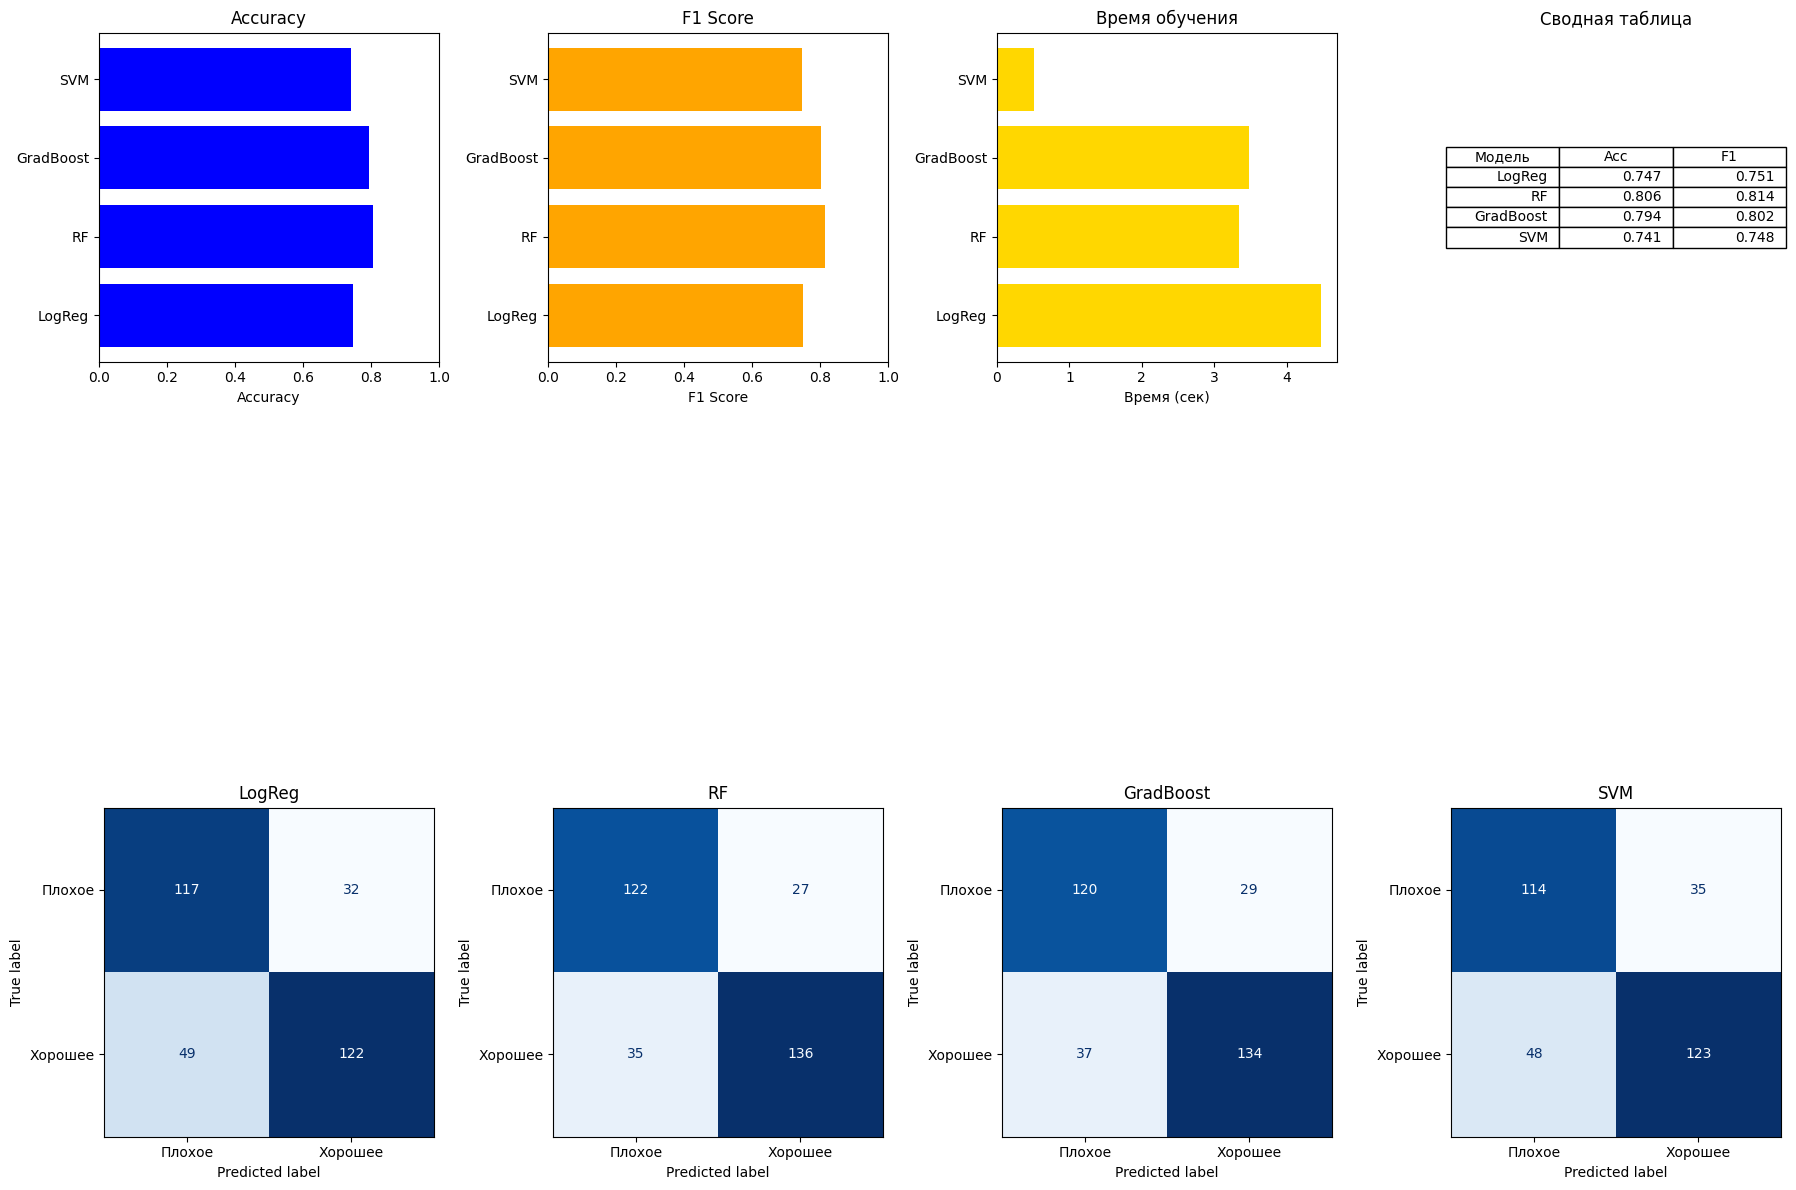


Подробный отчёт лучшей модели (RF):
              precision    recall  f1-score   support

      Плохое       0.78      0.82      0.80       149
     Хорошее       0.83      0.80      0.81       171

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



In [28]:
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

ax = axes[0, 0]
ax.barh(res_df['Модель'], res_df['Accuracy'], color='blue')
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy')
ax.set_xlim(0, 1)

ax = axes[0, 1]
ax.barh(res_df['Модель'], res_df['F1'], color='orange')
ax.set_xlabel('F1 Score')
ax.set_title('F1 Score')
ax.set_xlim(0, 1)

ax = axes[0, 2]
ax.barh(res_df['Модель'], res_df['Время_обуч'], color='gold')
ax.set_xlabel('Время (сек)')
ax.set_title('Время обучения')

ax = axes[0, 3]
ax.axis('off')
table_data = [[row['Модель'], f"{row['Accuracy']:.3f}", f"{row['F1']:.3f}"] for _, row in res_df.iterrows()]
ax.table(cellText=table_data, colLabels=['Модель', 'Acc', 'F1'], loc='center')
ax.set_title('Сводная таблица')

for ax in axes[1, :]:
    ax.axis('off')

for i, (name, model) in enumerate(best_models.items()):
    ax = axes[2, i]
    y_pred = model.predict(X_ts_sc)
    cm = confusion_matrix(y_ts, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Плохое', 'Хорошее']).plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f'{name}')

plt.tight_layout()
plt.show()

best_name = res_df.loc[res_df['F1'].idxmax(), 'Модель']
print(f"\nПодробный отчёт лучшей модели ({best_name}):")
y_pred_best = best_models[best_name].predict(X_ts_sc)
print(classification_report(y_ts, y_pred_best, target_names=['Плохое', 'Хорошее']))

## 7. Выводы

Анализ результатов моделей:

1. LogisticRegression: простая и быстрая модель, показывает базовый результат (Accuracy, как и F1 примерно 0.75)
2. RandomForest: ансамбль деревьев, показывает лучшее качество за счёт агрегаци (Accuracy около 0.8, F1 примерно 0.81)
3. GradientBoosting: последовательный ансамбль, достойный результат (Accuracy примерно 0.79, F1 - 0.79)
4. SVM: хорошо работает на масштабированных данных (Accuracy около 0.74, F1 - 0.75)

Анализ Confusion Matrices:
- Все модели лучше предсказывают класс "хорошее вино" (больше примеров в обучении)
- GradientBoosting и RandomForest имеют наименьшее количество ложных срабатываний

Итоговый вывод: RandomForest предпочтителен для данной задачи - он показывает лучший F1-score при приемлемом времени обучения. Датасет не требовал дополнительной очистки: пропусков нет, типы корректные, выбросы реальны и не мешают tree-based моделям.